# Test of the Facial Recognition Model with LFWA+ Dataset

### Install and Import Librairies

In [ ]:
!pip install mat73

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd

import sys
import os

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

from triplet import TripletGenerator, TripletLearner, TripletLoss

### Import Data

#### Import Images

In [ ]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

import tarfile
if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

Extracting image files...


In [ ]:
PATH = "lfw/lfw-deepfunneled/"
USE_SUBSET = True

In [ ]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:] #:500
    
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

number of classes: 5749


In [ ]:
# read all directories
img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(PATH+directory))] 
             for directory,c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v:k for k,v in enumerate(all_images_path)}
id_to_path = {v:k for k,v in path_to_id.items()}

In [ ]:
# build mappings between images and class
classid_to_ids = {k:[path_to_id[path] for path in v] for k,v in img_paths.items()}
id_to_classid = {v:c for c,imgs in classid_to_ids.items() for v in imgs}

In [ ]:
classid_to_path = img_paths

path_to_classid = {}
for key, value in classid_to_path.items():
    for string in value:
        path_to_classid.setdefault(string, key)

In [ ]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(PATH+path)),0)]
    return np.vstack(all_imgs)

In [ ]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((13233, 60, 60, 3), '1143.3312Mo')

#### Import Data Attributes

In [ ]:
data_dict = mat73.loadmat('lfw_att_73.mat')

In [ ]:
print(len(data_dict.name))
print(len(all_images_path))

13143
13233


In [ ]:
print(all_images_path[2])
print(data_dict.name[0])

Aaron_Eckhart/Aaron_Eckhart_0001.jpg
Aaron_Eckhart\Aaron_Eckhart_0001.jpg


In [ ]:
import re
stri = "Robin\\001"
print(re.sub('[\\\\]', '/', stri))

Robin/001


In [ ]:
def rewrite_names(name_list):
  new_list = []
  for stri in name_list:
    new_list.append(re.sub('[\\\\]', '/', stri))
  return(new_list)

In [ ]:
data_dict.name = rewrite_names(data_dict.name)

In [ ]:
list(set(all_images_path) - (set(all_images_path)-set(data_dict.name))) == data_dict.name

False

In [ ]:
print(len(list(set(all_images_path)-set(data_dict.name))))

90


In [ ]:
attributes = ['Name'] + data_dict.AttrName

In [ ]:
values = np.zeros((len(data_dict.name),len(data_dict.AttrName)+1),dtype=object)

for i in range(len(data_dict.name)):
  #df.iloc[i] = [data_dict.name[i]] + list(data_dict.label[i])
  values[i] = [data_dict.name[i]] + list(data_dict.label[i])

In [ ]:
df= pd.DataFrame(values, columns=attributes)

In [ ]:
df.insert(0,'Classid',np.nan)
for path,classid in path_to_classid.items():
    df['Classid'][df.Name==path]=int(classid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df[df['Child']==1]

,Classid,Name,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
67,34.0,Adam_Mair/Adam_Mair_0001.jpg,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
74,37.0,Adam_Scott/Adam_Scott_0002.jpg,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,1,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
113,58.0,Ahmad_Masood/Ahmad_Masood_0001.jpg,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
129,68.0,Aicha_El_Ouafi/Aicha_El_Ouafi_0002.jpg,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
139,67.0,Ai_Sugiyama/Ai_Sugiyama_0004.jpg,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13073,5708.0,Young_Kim/Young_Kim_0001.jpg,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
13098,5727.0,Zara_Akhmadova/Zara_Akhmadova_0001.jpg,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
13112,5736.0,Zhang_Ziyi/Zhang_Ziyi_0004.jpg,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
13127,5740.0,Zinedine_Zidane/Zinedine_Zidane_0002.jpg,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


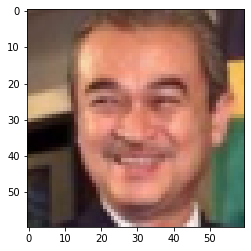

In [ ]:
plt.imshow(resize100(imread(PATH+"Abdullah_Ahmad_Badawi/Abdullah_Ahmad_Badawi_0001.jpg"))/255)

In [ ]:
print_from_id_df()

In [ ]:
def img_from_df(id_df):
  return all_imgs[path_to_id[df.iloc[id_df].Name]]

In [ ]:
def print_from_id_df(id_df):
    x = img_from_df(id_df).T
    for dim in range(3):
      x[dim] = x[dim].T

    x = x.transpose((1, 2, 0))
    plt.figure()
    plt.title(df.iloc[id_df].Name)
    plt.imshow((x + mean)/255)
    plt.axis('off')

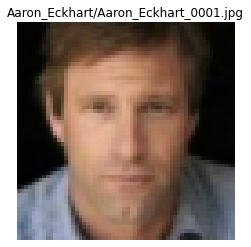

In [ ]:
id_df = 0
print_from_id_df(id_df)

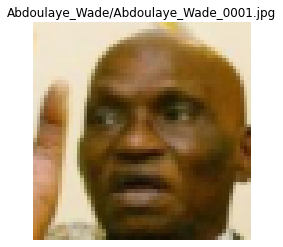

In [ ]:
black_1 = df[df.Black==1.0].index[0]
print_from_id_df(black_1)

In [ ]:
classid_Black = df['Classid'][df.Black==1].unique()
classid_White = df['Classid'][df.White==1].unique()

classid_Male = df['Classid'][df.Male==1].unique()
classid_Nonmale = df['Classid'][df.Male==0].unique()

In [ ]:
print('Number of Black people in the dataset: ', len(classid_Black))
print('Number of White people in the dataset: ', len(classid_White))
print('Number of Men in the dataset: ', len(classid_Men))
print('Number of Women in the dataset: ', len(classid_Women))

Number of Black people in the dataset:  367
Number of White people in the dataset:  4318
Number of Men in the dataset:  4390
Number of Women in the dataset:  1622


In [ ]:
df['Classid'].unique().shape

(5721,)

In [ ]:
df[(df['White']==0) & (df['Male']==0)]['Classid'].unique().shape

(512,)

In [ ]:
0.2*244

48.800000000000004

In [ ]:
df.columns

Index(['Classid', 'Name', 'Male', 'Asian', 'White', 'Black', 'Baby', 'Child',
       'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair',
       'Brown Hair', 'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses',
       'Mustache', 'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting',
       'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair',
       'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns',
       'Fully Visible Forehead', 'Partially Visible Forehead',
       'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows',
       'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips',
       'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open',
       'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw', 'Double Chin',
       'Wearing Hat', 'Oval Face', 'Square Face', 'Round Face', 'Color Photo',
       'Posed Photo', 'Attractive Man', 'Attractive Woman', 'Indian',
       'Gray Hair', 'Bags Under Eyes', 'Heavy Makeup', 'Rosy Cheeks'

In [ ]:
df[(df['White']==0)&(df['Black']==0)&(df['Asian']==0)&(df['Indian']==0)]

,Classid,Name,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
2,4.0,Aaron_Patterson/Aaron_Patterson_0001.jpg,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,1,0,0,0,1,1,0,1,1,0,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
11,9.0,Abba_Eban/Abba_Eban_0001.jpg,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,1,1
27,22.0,Abdullah_al-Attiyah/Abdullah_al-Attiyah_0001.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,1,0,1,0,1,0
29,22.0,Abdullah_al-Attiyah/Abdullah_al-Attiyah_0003.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0
32,20.0,Abdullah_Gul/Abdullah_Gul_0003.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,5728.0,Zarai_Toledo/Zarai_Toledo_0001.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
13100,5728.0,Zarai_Toledo/Zarai_Toledo_0002.jpg,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
13113,5737.0,Zhong_Nanshan/Zhong_Nanshan_0001.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
13132,5741.0,Ziwang_Xu/Ziwang_Xu_0001.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0


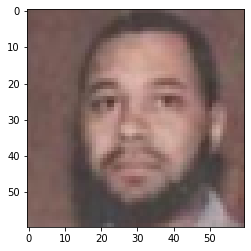

In [ ]:
plt.imshow(resize100(imread(PATH+"Aaron_Patterson/Aaron_Patterson_0001.jpg"))/255)

#### Build Triplet

In [ ]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    
    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [ ]:
def build_positive_pairs(class_id_range):
    listX1 = []
    listX2 = []
    
    for class_id in class_id_range:
        pos = build_pos_pairs_for_id(class_id)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            
    perm = np.random.permutation(len(listX1))
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [ ]:
split_num = int(num_classes * 0.8)

In [ ]:
Xa_train, Xp_train = build_positive_pairs(range(0, split_num))
Xa_test, Xp_test = build_positive_pairs(range(split_num, num_classes-1))

# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(Xa_train) | set(Xp_train))
all_img_test_idx = list(set(Xa_test) | set(Xp_test))

In [ ]:
Xa_train.shape, Xp_train.shape, all_imgs.shape

((12018,), (12018,), (13233, 60, 60, 3))

In [ ]:
Xa_black, Xp_black = build_positive_pairs(classid_Black)
Xa_white, Xp_white = build_positive_pairs(classid_White)
Xa_men, Xp_men = build_positive_pairs(classid_Men)
Xa_women, Xp_women = build_positive_pairs(classid_Women)

In [ ]:
print('Number of images of Black people: ', Xa_black.shape[0])
print('Number of images of White people: ', Xa_white.shape[0])
print('Number of images of Men: ', Xa_men.shape[0])
print('Number of images of Women: ', Xa_women.shape[0])

Number of images of Black people:  2254
Number of images of White people:  15145
Number of images of Men:  13329
Number of images of Women:  7044


### Import Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
BATCH_SIZE = 128
BATCH_TEST_SIZE = 32

In [ ]:
gen_train = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, all_imgs, all_img_train_idx)
train_loader = DataLoader(gen_train, batch_size=None, shuffle=True)

gen_test = TripletGenerator(Xa_test, Xp_test, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
test_loader = DataLoader(gen_test, batch_size=None, shuffle=True)

In [ ]:
model = TripletLearner()
model.load_state_dict(torch.load("./model1.pth"))
model.eval()

TripletLearner(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (16): ReLU()
    (17): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
model = model.to(device)

### Test Model

In [ ]:
xa,xp,xn = gen_test[0]

xa.shape, xp.shape, xn.shape

(torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]))

In [ ]:
margin = 1. #0.5
criterion = TripletLoss(margin)

In [ ]:
anchor_test = xa.to(device)
positive_test = xp.to(device)
negative_test = xn.to(device)

anchor_test_out = model(anchor_test)
positive_test_out = model(positive_test)
negative_test_out = model(negative_test)

test_loss = criterion(anchor_test_out, positive_test_out, negative_test_out)

print(test_loss)

tensor(0.2865, device='cuda:0', grad_fn=<MeanBackward0>)


### Test on different populations

In [ ]:
gen_black = TripletGenerator(Xa_black, Xp_black, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
black_loader = DataLoader(gen_black, batch_size=None, shuffle=True)

gen_white = TripletGenerator(Xa_white, Xp_white, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
white_loader = DataLoader(gen_white, batch_size=None, shuffle=True)

gen_men = TripletGenerator(Xa_men, Xp_men, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
men_loader = DataLoader(gen_men, batch_size=None, shuffle=True)

gen_women = TripletGenerator(Xa_women, Xp_women, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
women_loader = DataLoader(gen_women, batch_size=None, shuffle=True)

In [ ]:
xa,xp,xn = gen_white[0]

xa.shape, xp.shape, xn.shape

(torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]))

In [ ]:
anchor_test = xa.to(device)
positive_test = xp.to(device)
negative_test = xn.to(device)

anchor_test_out = model(anchor_test)
positive_test_out = model(positive_test)
negative_test_out = model(negative_test)

test_loss = criterion(anchor_test_out, positive_test_out, negative_test_out)

print(test_loss)

tensor(0.4782, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
xa,xp,xn = gen_black[0]

xa.shape, xp.shape, xn.shape

(torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]),
 torch.Size([32, 3, 60, 60]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


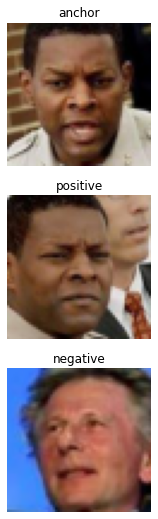

In [ ]:
plt.figure(figsize=(16, 9))

xa_num = xa.numpy()
xp_num = xp.numpy()
xn_num = xn.numpy()

x = xa_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 1)
plt.title("anchor")
plt.imshow((x + mean)/255)
plt.axis('off')
    
x = xp_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 6)
plt.title("positive")
plt.imshow((x + mean) / 255)
plt.axis('off')
    
x = xn_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 11)
plt.title("negative")
plt.imshow((x + mean) / 255)
plt.axis('off')
    
plt.show()

In [ ]:
anchor_test = xa.to(device)
positive_test = xp.to(device)
negative_test = xn.to(device)

anchor_test_out = model(anchor_test)
positive_test_out = model(positive_test)
negative_test_out = model(negative_test)

test_loss = criterion(anchor_test_out, positive_test_out, negative_test_out)

print(test_loss)

tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
epochs = 10
white_loss = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(white_loader, desc="Processing", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        
        running_loss.append(loss.cpu().detach().numpy())

    white_loss.append(np.mean(running_loss))

    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

print('Average loss on White people:', np.mean(white_loss))

Epoch: 1/10 - Loss: 0.1736


Epoch: 2/10 - Loss: 0.1690


Epoch: 3/10 - Loss: 0.1733


Epoch: 4/10 - Loss: 0.1768


Epoch: 5/10 - Loss: 0.1742


Epoch: 6/10 - Loss: 0.1721


Epoch: 7/10 - Loss: 0.1750


Epoch: 8/10 - Loss: 0.1718


Epoch: 9/10 - Loss: 0.1776


Epoch: 10/10 - Loss: 0.1700

Average loss on White people: 0.17334734


In [ ]:
black_loss = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(black_loader, desc="Processing", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        
        running_loss.append(loss.cpu().detach().numpy())

    black_loss.append(np.mean(running_loss))

    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

print('Average loss on Black people:', np.mean(black_loss))

Epoch: 1/10 - Loss: 0.1980


Epoch: 2/10 - Loss: 0.1930


Epoch: 3/10 - Loss: 0.1972


Epoch: 4/10 - Loss: 0.2029


Epoch: 5/10 - Loss: 0.2098


Epoch: 6/10 - Loss: 0.2120


Epoch: 7/10 - Loss: 0.2178


Epoch: 8/10 - Loss: 0.1979


Epoch: 9/10 - Loss: 0.2075


Epoch: 10/10 - Loss: 0.1904

Average loss on Black people: 0.20265362


In [ ]:
men_loss = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(men_loader, desc="Processing", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        
        running_loss.append(loss.cpu().detach().numpy())

    men_loss.append(np.mean(running_loss))

    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

print('Average loss on Men:', np.mean(men_loss))

Epoch: 1/10 - Loss: 0.1809


Epoch: 2/10 - Loss: 0.1798


Epoch: 3/10 - Loss: 0.1884


Epoch: 4/10 - Loss: 0.1798


Epoch: 5/10 - Loss: 0.1831


Epoch: 6/10 - Loss: 0.1833


Epoch: 7/10 - Loss: 0.1900


Epoch: 8/10 - Loss: 0.1842


Epoch: 9/10 - Loss: 0.1825


Epoch: 10/10 - Loss: 0.1873

Average loss on Men: 0.18391511


In [ ]:
women_loss = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(women_loader, desc="Processing", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        
        running_loss.append(loss.cpu().detach().numpy())

    women_loss.append(np.mean(running_loss))

    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

print('Average loss on Women:', np.mean(women_loss))

Epoch: 1/10 - Loss: 0.1654


Epoch: 2/10 - Loss: 0.1548


Epoch: 3/10 - Loss: 0.1585


Epoch: 4/10 - Loss: 0.1606


Epoch: 5/10 - Loss: 0.1608


Epoch: 6/10 - Loss: 0.1614


Epoch: 7/10 - Loss: 0.1594


Epoch: 8/10 - Loss: 0.1665


Epoch: 9/10 - Loss: 0.1648


Epoch: 10/10 - Loss: 0.1610

Average loss on Women: 0.16132832


### Similar images

In [ ]:
emb = shared_conv.predict(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)
pixelwise = np.reshape(all_imgs, (all_imgs.shape[0], 60*60*3))

In [ ]:
def most_sim(idx, topn=5, mode="euclidean"):
    x = emb[idx]
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id,sims[id]) for id in ids[:topn]]
    elif mode == "euclidean":
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(pixelwise - pixelwise[idx], axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1])>4, classid_to_ids.items()))
class_idx = random.choice(interesting_classes)[0]
print(class_idx)
img_idx = random.choice(classid_to_ids[class_idx])
for id, sim in most_sim(img_idx):
    display(all_imgs[id] + mean)
    print((classid_to_name[id_to_classid[id]], id, sim))

In [ ]:
test_ids = []
for class_id in range(split_num, num_classes-1):
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        test_ids += img_ids

In [ ]:
print(len(test_ids))

In [ ]:
len([len(classid_to_ids[x]) for x in list(range(split_num, num_classes-1)) if len(classid_to_ids[x])>1])

In [ ]:
def recall_k(k=10, mode="embedding"):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = []
        if mode == "embedding":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1)[1:]]
        elif mode == "random":
            found_classes = [id_to_classid[x] for x in random.sample(
                list(set(all_img_test_idx + all_img_train_idx) - {img_idx}), k)]
        elif mode == "image":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1, mode="image")[1:]]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)

In [ ]:
recall_k(k=10), recall_k(k=10, mode="random")

In [ ]:
# Naive way to compute all similarities between all images. May be optimized!
def build_similarities(conv, all_imgs):
    embs = conv.predict(all_imgs)
    embs = embs / np.linalg.norm(embs, axis=-1, keepdims=True)
    all_sims = np.dot(embs, embs.T)
    return all_sims

def intersect(a, b):
    return list(set(a) & set(b))

def build_negatives(anc_idxs, pos_idxs, similarities, neg_imgs_idx, num_retries=20):
    # If no similarities were computed, return a random negative
    if similarities is None:
        return random.sample(neg_imgs_idx,len(anc_idxs))
    final_neg = []
    # for each positive pair
    for (anc_idx, pos_idx) in zip(anc_idxs, pos_idxs):
        anchor_class = id_to_classid[anc_idx]
        #positive similarity
        sim = similarities[anc_idx, pos_idx]
        # find all negatives which are semi(hard)
        possible_ids = np.where((similarities[anc_idx] + 0.25) > sim)[0]
        possible_ids = intersect(neg_imgs_idx, possible_ids)
        appended = False
        for iteration in range(num_retries):
            if len(possible_ids) == 0:
                break
            idx_neg = random.choice(possible_ids)
            if id_to_classid[idx_neg] != anchor_class:
                final_neg.append(idx_neg)
                appended = True
                break
        if not appended:
            final_neg.append(random.choice(neg_imgs_idx))
    return final_neg

In [ ]:
class HardTripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx, conv):
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx

        if conv:
            print("Pre-computing similarities...", end=" ")
            self.similarities = build_similarities(conv, self.imgs)
            print("Done!")
        else:
            self.similarities = None
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs_a = self.Xa[low_index:high_index]
        imgs_p = self.Xp[low_index:high_index]
        imgs_n = build_negatives(imgs_a, imgs_p, self.similarities, self.neg_imgs_idx)
        
        imgs_a = seq.augment_images(self.imgs[imgs_a])
        imgs_p = seq.augment_images(self.imgs[imgs_p])
        imgs_n = seq.augment_images(self.imgs[imgs_n])
        
        return ([imgs_a, imgs_p, imgs_n], np.zeros(shape=(imgs_a.shape[0])))

In [ ]:
gen_hard = HardTripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx, shared_conv)
len(gen_hard)

In [ ]:
[xa, xp, xn], y = gen_hard[0]
xa.shape, xp.shape, xn.shape